<a href="https://colab.research.google.com/github/nitin-vig/ERAv4S7/blob/main/CIFAR10v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Cifar10 dataset with 85% test accuracy.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

**Compute Mean and Standard Deviation for Normalization of data**. Commented as it is needed only once

In [2]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# from tqdm import tqdm

# def get_mean_and_std(dataloader):
#     """
#     Calculate the mean and standard deviation of a dataset.

#     Args:
#         dataloader (DataLoader): The DataLoader for the dataset.

#     Returns:
#         tuple: The mean and standard deviation tensors for each channel.
#     """
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in tqdm(dataloader, desc="Calculating mean and std"):
#         # Mean over batch, height, and width, but not over the channels
#         channels_sum += torch.mean(data, dim=[0, 2, 3])
#         channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     # Std = sqrt(E[X^2] - (E[X])^2)
#     std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
#     return mean, std

# # 1. Load the dataset without normalization (only convert to tensor)
# # This will automatically download the dataset if it's not present
# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# # 2. Create a DataLoader
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

# # 3. Get the mean and standard deviation
# mean, std = get_mean_and_std(train_loader)

# print('Calculated Mean:', mean)
# print('Calculated Standard Deviation:', std)

# 100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]
# Calculating mean and std: 100%|██████████| 391/391 [00:06<00:00, 61.66it/s]
# Calculated Mean: tensor([0.4914, 0.4822, 0.4465])
# Calculated Standard Deviation: tensor([0.2470, 0.2435, 0.2616])

In [3]:
# Train Phase transformations
# train_transforms = transforms.Compose([

#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616),), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
#                                        A.CoarseDropout(num_holes_range=(1,1),hole_height_range=(16,16),hole_width_range=(16,16),p=0.5),
#                                        A.HorizontalFlip(0.5),
#                                        A.ShiftScaleRotate(shift_limit=1,scale_limit=1,rotate_limit=1,p=0.5)
#                                        ])
# Define your Albumentations pipeline
albumentations_transforms = A.Compose([
    A.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616),
    ),
    A.HorizontalFlip(0.5),
    A.ShiftScaleRotate(shift_limit=1,scale_limit=1,rotate_limit=1,p=0.5),
    A.CoarseDropout(
        num_holes=1,
        max_h_size=16,
        max_w_size=16,
        fill_value=0.4822,
        p=0.5
    ),
    ToTensorV2(),
])

# Use a lambda to wrap the Albumentations call
train_transforms = lambda img: albumentations_transforms(image=np.array(img))['image']


# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                                       ])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-817236643.py:18: UserWarning: Argument(s) 'num_holes, max_h_size, max_w_size, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170M/170M [00:41<00:00, 4.12MB/s]


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


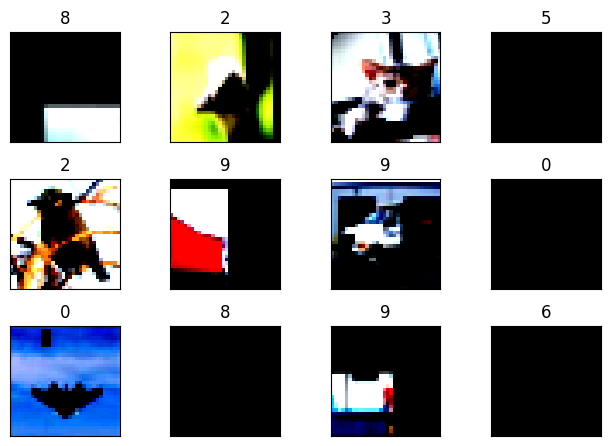

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  # plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.imshow(batch_data[i].permute(1,2,0))

  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define the multiple-layer convolutional block
        self.conv_block1 = nn.Sequential(nn.Conv2d(3, 16, 3, padding=16), # input size=64 , RF = 3, outputsize=62, Jout =1,
                                    nn.ReLU(), nn.BatchNorm2d(16),

                                    nn.Conv2d(16, 16, 3, padding=0),      # input size=62 , RF = 5, outputsize=60, Jout =1
                                    nn.ReLU(),nn.BatchNorm2d(16),

                                    # nn.Conv2d(16, 32, 3, padding=0),      # input size=60 , RF = 7, outputsize=58, Jout =1
                                    # This Depthwise Convolution reduced the params by 4k and can be replicated in other places in the model
                                    nn.Conv2d(16, 16, 3, padding=0, groups=16),
                                    nn.Conv2d(16, 32, kernel_size=1, bias=False),
                                    nn.ReLU(), nn.BatchNorm2d(32),


                                    nn.Conv2d(32, 64, 3, padding=0, stride=2),# input size=58 , RF = 9, outputsize=28, Jout=2
                                    nn.ReLU(),nn.BatchNorm2d(64),
                                  )


        self.conv_block2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
                                    nn.BatchNorm2d(16)) # input size=28 , RF = 9, outputsize=28, Jout=2

        self.conv_block3 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=0),# input size=28 , RF = 13, outputsize=26,Jout=2
                                    nn.ReLU(),nn.BatchNorm2d(32),

                                    nn.Conv2d(32, 64, 3, padding=0,dilation=2),# input size=26 , RF = 21, outputsize=22, Jout=2 # dilation of 2~ 5x5 kernel
                                    nn.ReLU(),nn.BatchNorm2d(64),

                                    nn.Conv2d(64, 64, 3, stride=2,padding=1),# input size=22 , RF = 25, outputsize=11, Jout=4
                                    nn.ReLU(),nn.BatchNorm2d(64),
                                    )

        self.conv_block4 = nn.Sequential(
                                    nn.Conv2d(64, 32, 3),# input size=11 , RF = 33, outputsize=9, Jout=4
                                    nn.ReLU(),nn.BatchNorm2d(32),

                                    nn.Conv2d(32, 32, 3),# input size=9 , RF = 41, outputsize=7, Jout=4
                                    nn.ReLU(),nn.BatchNorm2d(32),

                                    nn.Conv2d(32, 16, 3),# input size=7 , RF = 49, outputsize=5, Jout=4
                                    nn.ReLU(),nn.BatchNorm2d(16),

                                    nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
                                    nn.BatchNorm2d(10),
                                    nn.AvgPool2d(kernel_size=5)
                                    )

    def forward(self, x):
        # Block 1
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
       BatchNorm2d-3           [-1, 16, 62, 62]              32
            Conv2d-4           [-1, 16, 60, 60]           2,320
              ReLU-5           [-1, 16, 60, 60]               0
       BatchNorm2d-6           [-1, 16, 60, 60]              32
            Conv2d-7           [-1, 16, 58, 58]             160
            Conv2d-8           [-1, 32, 58, 58]             512
              ReLU-9           [-1, 32, 58, 58]               0
      BatchNorm2d-10           [-1, 32, 58, 58]              64
           Conv2d-11           [-1, 64, 28, 28]          18,496
             ReLU-12           [-1, 64, 28, 28]               0
      BatchNorm2d-13           [-1, 64, 28, 28]             128
           Conv2d-14           [-1

In [9]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1) ## Learning: adjust LR to a smaller value after every 5 epochs for fine tuning

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  # Update the learning rate
  scheduler.step()


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=1.83342707157135 Batch_id=195 Accuracy=26.84: 100%|██████████| 196/196 [00:22<00:00,  8.78it/s]



Test set: Average loss: 1.6016, Accuracy: 4161/10000 (41.61%)

EPOCH: 2


Loss=1.73443603515625 Batch_id=195 Accuracy=34.99: 100%|██████████| 196/196 [00:22<00:00,  8.90it/s]



Test set: Average loss: 1.3833, Accuracy: 4991/10000 (49.91%)

EPOCH: 3


Loss=1.597193956375122 Batch_id=195 Accuracy=38.90: 100%|██████████| 196/196 [00:26<00:00,  7.53it/s]



Test set: Average loss: 1.2108, Accuracy: 5808/10000 (58.08%)

EPOCH: 4


Loss=1.6613438129425049 Batch_id=195 Accuracy=41.74: 100%|██████████| 196/196 [00:26<00:00,  7.31it/s]



Test set: Average loss: 1.0727, Accuracy: 6196/10000 (61.96%)

EPOCH: 5


Loss=1.4254647493362427 Batch_id=195 Accuracy=43.78: 100%|██████████| 196/196 [00:23<00:00,  8.39it/s]



Test set: Average loss: 1.0536, Accuracy: 6245/10000 (62.45%)

EPOCH: 6


Loss=1.3208380937576294 Batch_id=195 Accuracy=45.77: 100%|██████████| 196/196 [00:24<00:00,  8.08it/s]



Test set: Average loss: 0.9568, Accuracy: 6620/10000 (66.20%)

EPOCH: 7


Loss=1.4379421472549438 Batch_id=195 Accuracy=47.07: 100%|██████████| 196/196 [00:22<00:00,  8.84it/s]



Test set: Average loss: 0.8946, Accuracy: 6902/10000 (69.02%)

EPOCH: 8


Loss=1.4439547061920166 Batch_id=195 Accuracy=48.49: 100%|██████████| 196/196 [00:24<00:00,  7.94it/s]



Test set: Average loss: 0.9504, Accuracy: 6712/10000 (67.12%)

EPOCH: 9


Loss=1.5654306411743164 Batch_id=195 Accuracy=49.36: 100%|██████████| 196/196 [00:22<00:00,  8.66it/s]



Test set: Average loss: 0.8286, Accuracy: 7102/10000 (71.02%)

EPOCH: 10


Loss=1.4109079837799072 Batch_id=195 Accuracy=50.06: 100%|██████████| 196/196 [00:21<00:00,  8.91it/s]



Test set: Average loss: 0.7573, Accuracy: 7400/10000 (74.00%)

EPOCH: 11


Loss=1.415095567703247 Batch_id=195 Accuracy=50.84: 100%|██████████| 196/196 [00:21<00:00,  9.20it/s]



Test set: Average loss: 0.7956, Accuracy: 7206/10000 (72.06%)

EPOCH: 12


Loss=1.3733117580413818 Batch_id=195 Accuracy=51.46: 100%|██████████| 196/196 [00:21<00:00,  9.03it/s]



Test set: Average loss: 0.7476, Accuracy: 7418/10000 (74.18%)

EPOCH: 13


Loss=1.2828246355056763 Batch_id=195 Accuracy=52.09: 100%|██████████| 196/196 [00:21<00:00,  9.30it/s]



Test set: Average loss: 0.7403, Accuracy: 7461/10000 (74.61%)

EPOCH: 14


Loss=1.376019835472107 Batch_id=195 Accuracy=52.12: 100%|██████████| 196/196 [00:22<00:00,  8.90it/s]



Test set: Average loss: 0.6835, Accuracy: 7641/10000 (76.41%)

EPOCH: 15


Loss=1.3283474445343018 Batch_id=195 Accuracy=53.05: 100%|██████████| 196/196 [00:22<00:00,  8.81it/s]



Test set: Average loss: 0.7145, Accuracy: 7529/10000 (75.29%)

EPOCH: 16


Loss=1.289289951324463 Batch_id=195 Accuracy=53.31: 100%|██████████| 196/196 [00:21<00:00,  8.91it/s]



Test set: Average loss: 0.6880, Accuracy: 7689/10000 (76.89%)

EPOCH: 17


Loss=1.3767726421356201 Batch_id=195 Accuracy=53.93: 100%|██████████| 196/196 [00:23<00:00,  8.50it/s]



Test set: Average loss: 0.6638, Accuracy: 7707/10000 (77.07%)

EPOCH: 18


Loss=1.2433757781982422 Batch_id=195 Accuracy=53.82: 100%|██████████| 196/196 [00:21<00:00,  8.95it/s]



Test set: Average loss: 0.7229, Accuracy: 7521/10000 (75.21%)

EPOCH: 19


Loss=1.2451550960540771 Batch_id=195 Accuracy=54.52: 100%|██████████| 196/196 [00:21<00:00,  8.94it/s]



Test set: Average loss: 0.6415, Accuracy: 7808/10000 (78.08%)

EPOCH: 20


Loss=1.3235323429107666 Batch_id=195 Accuracy=54.48: 100%|██████████| 196/196 [00:21<00:00,  9.26it/s]



Test set: Average loss: 0.6692, Accuracy: 7693/10000 (76.93%)

EPOCH: 21


Loss=1.180442452430725 Batch_id=195 Accuracy=54.97: 100%|██████████| 196/196 [00:21<00:00,  9.24it/s]



Test set: Average loss: 0.6249, Accuracy: 7862/10000 (78.62%)

EPOCH: 22


Loss=1.1680704355239868 Batch_id=195 Accuracy=55.50: 100%|██████████| 196/196 [00:21<00:00,  9.05it/s]



Test set: Average loss: 0.6001, Accuracy: 7964/10000 (79.64%)

EPOCH: 23


Loss=1.09671151638031 Batch_id=195 Accuracy=55.54: 100%|██████████| 196/196 [00:21<00:00,  8.92it/s]



Test set: Average loss: 0.6060, Accuracy: 7926/10000 (79.26%)

EPOCH: 24


Loss=1.1347911357879639 Batch_id=195 Accuracy=55.82: 100%|██████████| 196/196 [00:21<00:00,  8.98it/s]



Test set: Average loss: 0.5983, Accuracy: 7986/10000 (79.86%)

EPOCH: 25


Loss=1.1016184091567993 Batch_id=195 Accuracy=56.00: 100%|██████████| 196/196 [00:22<00:00,  8.87it/s]



Test set: Average loss: 0.5910, Accuracy: 8028/10000 (80.28%)

EPOCH: 26


Loss=1.4011716842651367 Batch_id=195 Accuracy=56.48: 100%|██████████| 196/196 [00:21<00:00,  8.96it/s]



Test set: Average loss: 0.5705, Accuracy: 8059/10000 (80.59%)

EPOCH: 27


Loss=1.1341474056243896 Batch_id=195 Accuracy=56.45: 100%|██████████| 196/196 [00:21<00:00,  9.25it/s]



Test set: Average loss: 0.5918, Accuracy: 8019/10000 (80.19%)

EPOCH: 28


Loss=1.1503747701644897 Batch_id=195 Accuracy=56.56: 100%|██████████| 196/196 [00:21<00:00,  9.32it/s]



Test set: Average loss: 0.5607, Accuracy: 8074/10000 (80.74%)

EPOCH: 29


Loss=1.0961410999298096 Batch_id=195 Accuracy=57.23: 100%|██████████| 196/196 [00:22<00:00,  8.73it/s]



Test set: Average loss: 0.5525, Accuracy: 8131/10000 (81.31%)

EPOCH: 30


Loss=1.1231920719146729 Batch_id=195 Accuracy=57.11: 100%|██████████| 196/196 [00:21<00:00,  9.10it/s]



Test set: Average loss: 0.6013, Accuracy: 7980/10000 (79.80%)

EPOCH: 31


Loss=1.2566182613372803 Batch_id=195 Accuracy=57.54: 100%|██████████| 196/196 [00:22<00:00,  8.74it/s]



Test set: Average loss: 0.5425, Accuracy: 8127/10000 (81.27%)

EPOCH: 32


Loss=1.1236019134521484 Batch_id=195 Accuracy=57.55: 100%|██████████| 196/196 [00:22<00:00,  8.72it/s]



Test set: Average loss: 0.6418, Accuracy: 7870/10000 (78.70%)

EPOCH: 33


Loss=1.0758527517318726 Batch_id=195 Accuracy=57.56: 100%|██████████| 196/196 [00:21<00:00,  8.99it/s]



Test set: Average loss: 0.5290, Accuracy: 8206/10000 (82.06%)

EPOCH: 34


Loss=1.1781705617904663 Batch_id=195 Accuracy=58.03: 100%|██████████| 196/196 [00:22<00:00,  8.87it/s]



Test set: Average loss: 0.5379, Accuracy: 8172/10000 (81.72%)

EPOCH: 35


Loss=1.0692310333251953 Batch_id=195 Accuracy=57.89: 100%|██████████| 196/196 [00:21<00:00,  9.29it/s]



Test set: Average loss: 0.5801, Accuracy: 8037/10000 (80.37%)

EPOCH: 36


Loss=1.2671226263046265 Batch_id=195 Accuracy=57.85: 100%|██████████| 196/196 [00:20<00:00,  9.44it/s]



Test set: Average loss: 0.5356, Accuracy: 8183/10000 (81.83%)

EPOCH: 37


Loss=1.0798598527908325 Batch_id=195 Accuracy=58.26: 100%|██████████| 196/196 [00:20<00:00,  9.35it/s]



Test set: Average loss: 0.5530, Accuracy: 8123/10000 (81.23%)

EPOCH: 38


Loss=1.1630990505218506 Batch_id=195 Accuracy=58.66: 100%|██████████| 196/196 [00:21<00:00,  9.05it/s]



Test set: Average loss: 0.5348, Accuracy: 8202/10000 (82.02%)

EPOCH: 39


Loss=1.2335563898086548 Batch_id=195 Accuracy=58.79: 100%|██████████| 196/196 [00:22<00:00,  8.86it/s]



Test set: Average loss: 0.5370, Accuracy: 8173/10000 (81.73%)

EPOCH: 40


Loss=1.0818525552749634 Batch_id=195 Accuracy=58.88: 100%|██████████| 196/196 [00:21<00:00,  8.95it/s]



Test set: Average loss: 0.5426, Accuracy: 8184/10000 (81.84%)

EPOCH: 41


Loss=1.1839672327041626 Batch_id=195 Accuracy=59.62: 100%|██████████| 196/196 [00:22<00:00,  8.55it/s]



Test set: Average loss: 0.4851, Accuracy: 8388/10000 (83.88%)

EPOCH: 42


Loss=1.0313597917556763 Batch_id=195 Accuracy=60.69: 100%|██████████| 196/196 [00:20<00:00,  9.35it/s]



Test set: Average loss: 0.4808, Accuracy: 8416/10000 (84.16%)

EPOCH: 43


Loss=0.9756035804748535 Batch_id=195 Accuracy=60.80: 100%|██████████| 196/196 [00:20<00:00,  9.36it/s]



Test set: Average loss: 0.4777, Accuracy: 8416/10000 (84.16%)

EPOCH: 44


Loss=1.1812334060668945 Batch_id=195 Accuracy=60.90: 100%|██████████| 196/196 [00:21<00:00,  9.12it/s]



Test set: Average loss: 0.4778, Accuracy: 8407/10000 (84.07%)

EPOCH: 45


Loss=1.2265733480453491 Batch_id=195 Accuracy=60.97: 100%|██████████| 196/196 [00:22<00:00,  8.84it/s]



Test set: Average loss: 0.4738, Accuracy: 8433/10000 (84.33%)

EPOCH: 46


Loss=1.131704568862915 Batch_id=195 Accuracy=60.86: 100%|██████████| 196/196 [00:21<00:00,  8.92it/s]



Test set: Average loss: 0.4732, Accuracy: 8444/10000 (84.44%)

EPOCH: 47


Loss=0.8954204320907593 Batch_id=195 Accuracy=61.10: 100%|██████████| 196/196 [00:21<00:00,  8.99it/s]



Test set: Average loss: 0.4722, Accuracy: 8427/10000 (84.27%)

EPOCH: 48


Loss=1.1057285070419312 Batch_id=195 Accuracy=60.95: 100%|██████████| 196/196 [00:22<00:00,  8.89it/s]



Test set: Average loss: 0.4734, Accuracy: 8451/10000 (84.51%)

EPOCH: 49


Loss=1.0914275646209717 Batch_id=195 Accuracy=61.15: 100%|██████████| 196/196 [00:21<00:00,  9.14it/s]



Test set: Average loss: 0.4717, Accuracy: 8427/10000 (84.27%)

EPOCH: 50


Loss=1.1885192394256592 Batch_id=195 Accuracy=61.48: 100%|██████████| 196/196 [00:20<00:00,  9.34it/s]



Test set: Average loss: 0.4697, Accuracy: 8438/10000 (84.38%)



Text(0.5, 1.0, 'Test Accuracy')

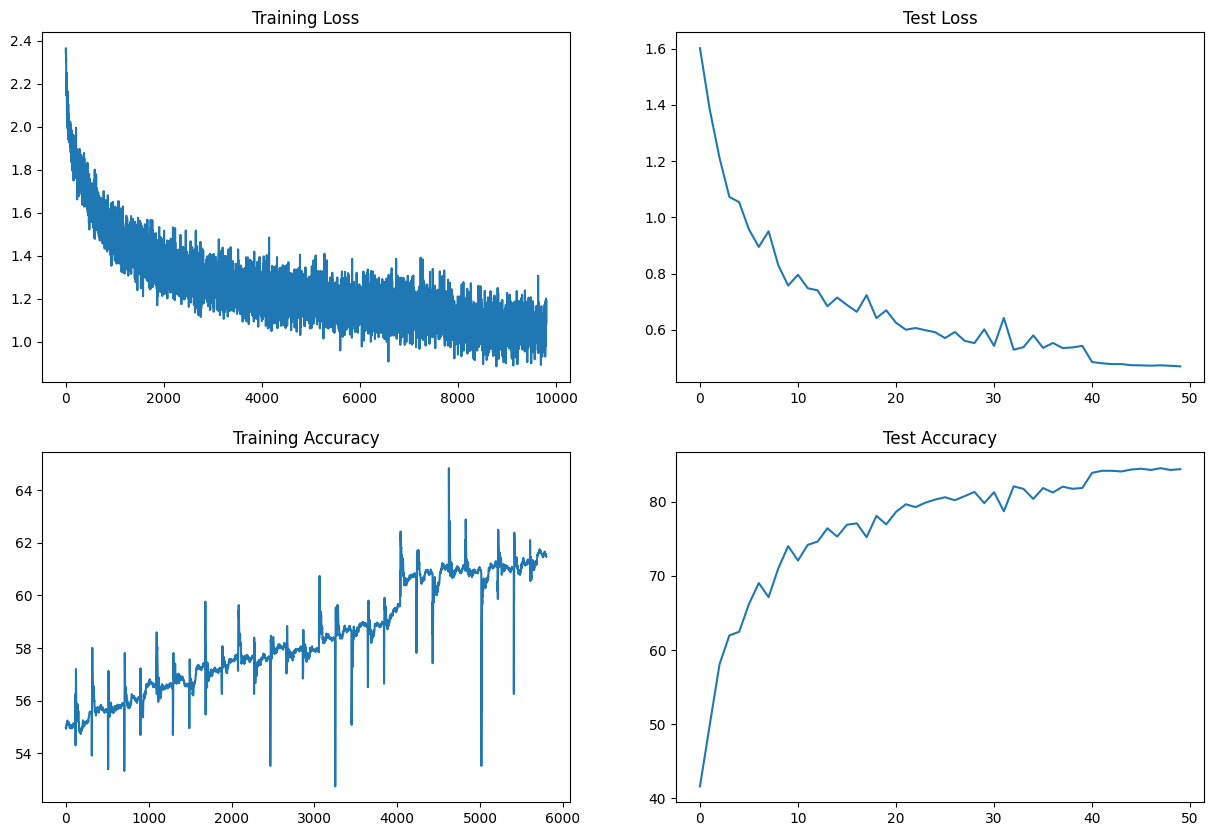

In [12]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")